In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 1️⃣ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Set paths
zip_path = '/content/drive/MyDrive/Emotion-Project.zip'
extract_path = '/content/Emotion-Project'

# 3️⃣ Unzip
!unzip -q "{zip_path}" -d "{extract_path}"
print("✅ Unzipped successfully at:", extract_path)


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Unzipped successfully at: /content/Emotion-Project


In [ ]:
# Cell 1: Imports & Paths
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture
from google.colab import files

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
# === COLAB PATHS ===
FER_TRAIN = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/train'
FER_TEST  = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/test'
MUSIC_INFO = '/content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/Music Info.csv'
USER_HISTORY = '/content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/User Listening History.csv'
MP3_FOLDER = '/content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/MP3-Example'  # optional

print('Paths set:')
print('FER_TRAIN =', FER_TRAIN)
print('FER_TEST  =', FER_TEST)
print('MUSIC_INFO =', MUSIC_INFO)
print('USER_HISTORY =', USER_HISTORY)
print('MP3_FOLDER =', MP3_FOLDER)

Paths set:
FER_TRAIN = /content/Emotion-Project/Emotion-Project/facial_detection_dataset/train
FER_TEST  = /content/Emotion-Project/Emotion-Project/facial_detection_dataset/test
MUSIC_INFO = /content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/Music Info.csv
USER_HISTORY = /content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/User Listening History.csv
MP3_FOLDER = /content/Emotion-Project/Emotion-Project/movie_recommendation_dataset/MP3-Example


In [ ]:
import os

# Check train folder
print("Train folder contents:", os.listdir(FER_TRAIN)[:7])  # first 5 folders

# Check test folder
print("Test folder contents:", os.listdir(FER_TEST)[:7])

# Check CSV files
print("Music Info exists?", os.path.exists(MUSIC_INFO))
print("User History exists?", os.path.exists(USER_HISTORY))


Train folder contents: ['surprise', 'angry', 'disgust', 'neutral', 'happy', 'fear', 'sad']
Test folder contents: ['surprise', 'angry', 'disgust', 'neutral', 'happy', 'fear', 'sad']
Music Info exists? False
User History exists? False


In [ ]:
# --- Step 1: Upload CSVs if they are not in Colab ---
print("If CSV files are not in Colab, upload them now:")
uploaded = files.upload()  # Select 'Music Info.csv' and 'User Listening History.csv'

# --- Step 2: Set paths (Colab will use the uploaded files) ---
MUSIC_INFO = "Music Info.csv"
USER_HISTORY = "User Listening History.csv"

# Verify files exist
assert os.path.exists(MUSIC_INFO), f"{MUSIC_INFO} not found!"
assert os.path.exists(USER_HISTORY), f"{USER_HISTORY} not found!"

# --- Step 3: Load data ---
music_df = pd.read_csv(MUSIC_INFO)
user_df = pd.read_csv(USER_HISTORY)

# --- Step 4: Basic cleaning ---
music_df = music_df.drop_duplicates().dropna(subset=['track_id','artist','name'])
user_df = user_df.drop_duplicates().dropna(subset=['user_id','track_id'])

for col in ['artist','name','genre']:
    if col in music_df.columns:
        music_df[col] = music_df[col].astype(str).str.lower().str.strip()

# --- Step 5: Merge datasets ---
merged_df = user_df.merge(music_df, on='track_id', how='left')
print('Merged shape:', merged_df.shape)

# --- Step 6: Features for emotion detection ---
features = ['valence','energy','danceability','acousticness','instrumentalness','liveness','tempo']
X = merged_df[features].fillna(0)

# --- Step 7: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 8: Gaussian Mixture Model for clustering ---
n_emotions = 7
gmm = GaussianMixture(n_components=n_emotions, random_state=42)
merged_df['emotion_cluster'] = gmm.fit_predict(X_scaled)

# --- Step 9: Inspect cluster centers ---
cluster_centers = scaler.inverse_transform(gmm.means_)
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}: {dict(zip(features, center))}")

# --- Step 10: Map clusters → emotions ---
cluster_to_emotion = {
    0: 'happy',
    1: 'sad',
    2: 'angry',
    3: 'fear',
    4: 'neutral',
    5: 'disgust',
    6: 'surprise'
}

# Force all emotions to appear
unique_clusters = merged_df['emotion_cluster'].unique()
missing_clusters = set(range(n_emotions)) - set(unique_clusters)
for idx, missing in enumerate(missing_clusters):
    cluster_to_emotion[missing] = ['happy','sad','angry','fear','neutral','disgust','surprise'][missing]

# Map cluster → emotion
merged_df['emotion_mapped'] = merged_df['emotion_cluster'].map(cluster_to_emotion)

# --- Step 11: Check results ---
print(merged_df[['artist','name','valence','energy','danceability','tempo','emotion_mapped']].head())
print("Emotions detected:", merged_df['emotion_mapped'].value_counts())


If CSV files are not in Colab, upload them now:


Saving Music Info.csv to Music Info.csv
Saving User Listening History.csv to User Listening History.csv
Merged shape: (9711301, 23)
Cluster 0: {'valence': np.float64(0.372854142028143), 'energy': np.float64(0.48839760225014284), 'danceability': np.float64(0.5213089435030724), 'acousticness': np.float64(0.4737472367492935), 'instrumentalness': np.float64(0.4383724783655603), 'liveness': np.float64(0.10586154951154081), 'tempo': np.float64(118.76859386391698)}
Cluster 1: {'valence': np.float64(0.5546791228186744), 'energy': np.float64(0.7058259032035), 'danceability': np.float64(0.5822392825400008), 'acousticness': np.float64(0.11055967438160534), 'instrumentalness': np.float64(0.00011717358015922441), 'liveness': np.float64(0.1953595774408455), 'tempo': np.float64(124.12478757381749)}
Cluster 2: {'valence': np.float64(0.411655098216315), 'energy': np.float64(0.8482385967692712), 'danceability': np.float64(0.4683821825575008), 'acousticness': np.float64(0.001126136803611788), 'instrument

In [ ]:
import os
from google.colab import drive

# ✅ 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# ✅ 2️⃣ Folder path in Google Drive
DRIVE_DATA_DIR = "/content/drive/MyDrive/Music_Emotion_Project/"
os.makedirs(DRIVE_DATA_DIR, exist_ok=True)

# ✅ 3️⃣ Save merged dataset to Drive
save_path = os.path.join(DRIVE_DATA_DIR, "Final_Music_Emotion_Data.csv")
merged_df.to_csv(save_path, index=False)

print(f"✅ Saved merged dataset to Google Drive at: {save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Saved merged dataset to Google Drive at: /content/drive/MyDrive/Music_Emotion_Project/Final_Music_Emotion_Data.csv


In [ ]:
# ------------------------------
BATCH = 32
IMG_SIZE = 48
num_classes = 7  # will be updated after generator
FER_TRAIN =  '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/train'

# ------------------------------
# Data Generators
# ------------------------------

# Training generator with strong augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    FER_TRAIN,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    FER_TRAIN,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation'
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Num classes:", num_classes)
print("Class indices:", class_indices)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num classes: 7
Class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# --- ✅ CNN Model ---
cnn_model = Sequential()

# Block 1
cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Dropout(0.25))  # slightly reduced

# Block 2
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Dropout(0.3))  # slightly reduced

# Block 3
cnn_model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.0005)))  # smaller L2
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2,2)))
cnn_model.add(Dropout(0.4))

# Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(num_classes, activation='softmax'))

# Compile
cnn_model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint('best_cnn_balanced.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Training
history_cnn = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=callbacks
)

# Save final model
cnn_model.save('cnn_balanced_model.h5')
print("✅ Balanced CNN trained and saved successfully.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1888 - loss: 2.7722
Epoch 1: val_accuracy improved from -inf to 0.27013, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 55s 49ms/step - accuracy: 0.1888 - loss: 2.7710 - val_accuracy: 0.2701 - val_loss: 1.8800
Epoch 2/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2144 - loss: 1.8949
Epoch 2: val_accuracy improved from 0.27013 to 0.27069, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.2145 - loss: 1.8949 - val_accuracy: 0.2707 - val_loss: 1.8979
Epoch 3/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2406 - loss: 1.8687
Epoch 3: val_accuracy improved from 0.27069 to 0.27529, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.2406 - loss: 1.8687 - val_accuracy: 0.2753 - val_loss: 1.8700
Epoch 4/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2426 - loss: 1.8585
Epoch 4: val_accuracy did not improve from 0.27529
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2426 - loss: 1.8585 - val_accuracy: 0.2750 - val_loss: 1.8297
Epoch 5/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2405 - loss: 1.8564
Epoch 5: val_accuracy improved from 0.27529 to 0.28671, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2405 - loss: 1.8564 - val_accuracy: 0.2867 - val_loss: 1.8589
Epoch 6/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2511 - loss: 1.8407
Epoch 6: val_accuracy did not improve from 0.28671
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2511 - loss: 1.8407 - val_accuracy: 0.2841 - val_loss: 1.8783
Epoch 7/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2559 - loss: 1.8417
Epoch 7: val_accuracy improved from 0.28671 to 0.29089, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.2559 - loss: 1.8417 - val_accuracy: 0.2909 - val_loss: 1.8983
Epoch 8/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2528 - loss: 1.8362
Epoch 8: val_accuracy improved from 0.29089 to 0.30022, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2528 - loss: 1.8362 - val_accuracy: 0.3002 - val_loss: 1.8491
Epoch 9/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2663 - loss: 1.8244
Epoch 9: val_accuracy improved from 0.30022 to 0.31374, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2663 - loss: 1.8244 - val_accuracy: 0.3137 - val_loss: 1.7658
Epoch 10/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2682 - loss: 1.8149
Epoch 10: val_accuracy did not improve from 0.31374
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.2682 - loss: 1.8149 - val_accuracy: 0.2984 - val_loss: 1.7786
Epoch 11/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2610 - loss: 1.8101
Epoch 11: val_accuracy improved from 0.31374 to 0.32419, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2610 - loss: 1.8101 - val_accuracy: 0.3242 - val_loss: 1.7073
Epoch 12/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2743 - loss: 1.7972
Epoch 12: val_accuracy improved from 0.32419 to 0.32767, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2743 - loss: 1.7972 - val_accuracy: 0.3277 - val_loss: 1.7038
Epoch 13/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2784 - loss: 1.7915
Epoch 13: val_accuracy improved from 0.32767 to 0.32962, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2785 - loss: 1.7915 - val_accuracy: 0.3296 - val_loss: 1.7330
Epoch 14/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2845 - loss: 1.7709
Epoch 14: val_accuracy did not improve from 0.32962
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2845 - loss: 1.7709 - val_accuracy: 0.3240 - val_loss: 1.8453
Epoch 15/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2933 - loss: 1.7655
Epoch 15: val_accuracy improved from 0.32962 to 0.34550, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.2933 - loss: 1.7655 - val_accuracy: 0.3455 - val_loss: 1.6457
Epoch 16/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2955 - loss: 1.7615
Epoch 16: val_accuracy did not improve from 0.34550
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.2955 - loss: 1.7615 - val_accuracy: 0.3313 - val_loss: 1.8611
Epoch 17/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3002 - loss: 1.7571
Epoch 17: val_accuracy improved from 0.34550 to 0.35024, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3002 - loss: 1.7571 - val_accuracy: 0.3502 - val_loss: 1.6747
Epoch 18/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3057 - loss: 1.7483
Epoch 18: val_accuracy did not improve from 0.35024
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.3057 - loss: 1.7483 - val_accuracy: 0.3490 - val_loss: 1.6931
Epoch 19/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3137 - loss: 1.7253
Epoch 19: val_accuracy did not improve from 0.35024
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3137 - loss: 1.7253 - val_accuracy: 0.3493 - val_loss: 1.7037
Epoch 20/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3198 - loss: 1.7229
Epoch 20: val_accuracy improved from 0.35024 to 0.37030, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3198 - loss: 1.7229 - val_accuracy: 0.3703 - val_loss: 1.6420
Epoch 21/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3164 - loss: 1.7209
Epoch 21: val_accuracy did not improve from 0.37030
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3164 - loss: 1.7208 - val_accuracy: 0.3614 - val_loss: 1.6984
Epoch 22/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3321 - loss: 1.7040
Epoch 22: val_accuracy improved from 0.37030 to 0.37935, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.3321 - loss: 1.7040 - val_accuracy: 0.3794 - val_loss: 1.6234
Epoch 23/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3346 - loss: 1.6908
Epoch 23: val_accuracy improved from 0.37935 to 0.39370, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3346 - loss: 1.6908 - val_accuracy: 0.3937 - val_loss: 1.5777
Epoch 24/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3413 - loss: 1.6770
Epoch 24: val_accuracy improved from 0.39370 to 0.39830, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3413 - loss: 1.6770 - val_accuracy: 0.3983 - val_loss: 1.5668
Epoch 25/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3404 - loss: 1.6695
Epoch 25: val_accuracy improved from 0.39830 to 0.41934, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3404 - loss: 1.6695 - val_accuracy: 0.4193 - val_loss: 1.5399
Epoch 26/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3503 - loss: 1.6555
Epoch 26: val_accuracy improved from 0.41934 to 0.43076, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.3503 - loss: 1.6555 - val_accuracy: 0.4308 - val_loss: 1.5126
Epoch 27/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3602 - loss: 1.6481
Epoch 27: val_accuracy improved from 0.43076 to 0.44246, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3601 - loss: 1.6481 - val_accuracy: 0.4425 - val_loss: 1.4886
Epoch 28/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3623 - loss: 1.6446
Epoch 28: val_accuracy improved from 0.44246 to 0.44539, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3623 - loss: 1.6446 - val_accuracy: 0.4454 - val_loss: 1.4889
Epoch 29/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3617 - loss: 1.6394
Epoch 29: val_accuracy improved from 0.44539 to 0.45040, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.3617 - loss: 1.6394 - val_accuracy: 0.4504 - val_loss: 1.4813
Epoch 30/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3622 - loss: 1.6306
Epoch 30: val_accuracy improved from 0.45040 to 0.45458, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.3622 - loss: 1.6306 - val_accuracy: 0.4546 - val_loss: 1.4548
Epoch 31/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3675 - loss: 1.6244
Epoch 31: val_accuracy did not improve from 0.45458
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3675 - loss: 1.6244 - val_accuracy: 0.4264 - val_loss: 1.4975
Epoch 32/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3754 - loss: 1.6105
Epoch 32: val_accuracy did not improve from 0.45458
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3755 - loss: 1.6105 - val_accuracy: 0.4430 - val_loss: 1.4751
Epoch 33/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3802 - loss: 1.6010
Epoch 33: val_accuracy improved from 0.45458 to 0.46350, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.3802 - loss: 1.6010 - val_accuracy: 0.4635 - val_loss: 1.4431
Epoch 34/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3823 - loss: 1.5936
Epoch 34: val_accuracy improved from 0.46350 to 0.48077, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3823 - loss: 1.5936 - val_accuracy: 0.4808 - val_loss: 1.4035
Epoch 35/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3818 - loss: 1.5982
Epoch 35: val_accuracy did not improve from 0.48077
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3818 - loss: 1.5982 - val_accuracy: 0.4691 - val_loss: 1.4004
Epoch 36/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4033 - loss: 1.5648
Epoch 36: val_accuracy did not improve from 0.48077
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4033 - loss: 1.5648 - val_accuracy: 0.4309 - val_loss: 1.4728
Epoch 37/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3956 - loss: 1.5687
Epoch 37: val_accuracy improved from 0.48077 to 0.48342, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.3956 - loss: 1.5687 - val_accuracy: 0.4834 - val_loss: 1.3866
Epoch 38/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3966 - loss: 1.5674
Epoch 38: val_accuracy improved from 0.48342 to 0.48899, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.3966 - loss: 1.5674 - val_accuracy: 0.4890 - val_loss: 1.3691
Epoch 39/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3972 - loss: 1.5573
Epoch 39: val_accuracy did not improve from 0.48899
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.3973 - loss: 1.5573 - val_accuracy: 0.4886 - val_loss: 1.3622
Epoch 40/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3994 - loss: 1.5626
Epoch 40: val_accuracy improved from 0.48899 to 0.49248, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.3994 - loss: 1.5626 - val_accuracy: 0.4925 - val_loss: 1.3459
Epoch 41/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4090 - loss: 1.5516
Epoch 41: val_accuracy did not improve from 0.49248
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4090 - loss: 1.5515 - val_accuracy: 0.4695 - val_loss: 1.4109
Epoch 42/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4091 - loss: 1.5345
Epoch 42: val_accuracy did not improve from 0.49248
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4091 - loss: 1.5345 - val_accuracy: 0.4911 - val_loss: 1.3549
Epoch 43/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4142 - loss: 1.5315
Epoch 43: val_accuracy improved from 0.49248 to 0.50947, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4142 - loss: 1.5316 - val_accuracy: 0.5095 - val_loss: 1.3204
Epoch 44/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4154 - loss: 1.5316
Epoch 44: val_accuracy did not improve from 0.50947
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4155 - loss: 1.5316 - val_accuracy: 0.4943 - val_loss: 1.3496
Epoch 45/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4158 - loss: 1.5285
Epoch 45: val_accuracy did not improve from 0.50947
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4158 - loss: 1.5285 - val_accuracy: 0.4902 - val_loss: 1.3408
Epoch 46/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4199 - loss: 1.5216
Epoch 46: val_accuracy did not improve from 0.50947
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4199 - loss: 1.5216 - val_accuracy: 0.4951 - val_loss: 1.3545
Epoch 47/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4232 - loss: 1.5113
Epoch 47: val_ac

898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.4232 - loss: 1.5113 - val_accuracy: 0.5145 - val_loss: 1.2972
Epoch 48/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4274 - loss: 1.5134
Epoch 48: val_accuracy did not improve from 0.51449
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4274 - loss: 1.5134 - val_accuracy: 0.5077 - val_loss: 1.3156
Epoch 49/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4248 - loss: 1.5135
Epoch 49: val_accuracy did not improve from 0.51449
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4248 - loss: 1.5135 - val_accuracy: 0.4993 - val_loss: 1.3507
Epoch 50/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4305 - loss: 1.4965
Epoch 50: val_accuracy improved from 0.51449 to 0.51700, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.4305 - loss: 1.4965 - val_accuracy: 0.5170 - val_loss: 1.2850
Epoch 51/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4325 - loss: 1.4978
Epoch 51: val_accuracy improved from 0.51700 to 0.52006, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4325 - loss: 1.4978 - val_accuracy: 0.5201 - val_loss: 1.2895
Epoch 52/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4321 - loss: 1.4933
Epoch 52: val_accuracy did not improve from 0.52006
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4321 - loss: 1.4933 - val_accuracy: 0.5185 - val_loss: 1.2788
Epoch 53/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4332 - loss: 1.4862
Epoch 53: val_accuracy improved from 0.52006 to 0.52689, saving model to best_cnn_balanced.h5


898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4332 - loss: 1.4862 - val_accuracy: 0.5269 - val_loss: 1.2571
Epoch 54/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4308 - loss: 1.4913
Epoch 54: val_accuracy did not improve from 0.52689
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4308 - loss: 1.4913 - val_accuracy: 0.5173 - val_loss: 1.2928
Epoch 55/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4360 - loss: 1.4804
Epoch 55: val_accuracy did not improve from 0.52689
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4360 - loss: 1.4803 - val_accuracy: 0.5157 - val_loss: 1.2812
Epoch 56/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4349 - loss: 1.4728
Epoch 56: val_accuracy did not improve from 0.52689
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4349 - loss: 1.4729 - val_accuracy: 0.5079 - val_loss: 1.3029
Epoch 57/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4407 - loss: 1.4734
Epoch 57: val_ac

898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4407 - loss: 1.4733 - val_accuracy: 0.5339 - val_loss: 1.2408
Epoch 58/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4463 - loss: 1.4661
Epoch 58: val_accuracy did not improve from 0.53385
898/898 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.4463 - loss: 1.4661 - val_accuracy: 0.5224 - val_loss: 1.2684
Epoch 59/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4433 - loss: 1.4617
Epoch 59: val_accuracy did not improve from 0.53385
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4432 - loss: 1.4617 - val_accuracy: 0.5322 - val_loss: 1.2500
Epoch 60/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4399 - loss: 1.4716
Epoch 60: val_accuracy did not improve from 0.53385
898/898 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.4399 - loss: 1.4716 - val_accuracy: 0.5192 - val_loss: 1.2805
Restoring model weights from the end of the best epoch: 57.


✅ Balanced CNN trained and saved successfully.


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# CNN ke liye alag folder
DRIVE_MODEL_DIR = "/content/drive/MyDrive/cnn_gray_models/"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save full CNN model
cnn_model.save(os.path.join(DRIVE_MODEL_DIR, "cnn_balanced_model.h5"))

# Save only best model checkpoint
!cp best_cnn_balanced.h5 "$DRIVE_MODEL_DIR/best_cnn_balanced.h5"

print("✅ CNN balanced model saved to Google Drive at:", DRIVE_MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CNN balanced model saved to Google Drive at: /content/drive/MyDrive/cnn_gray_models/


In [ ]:
import pickle, os
from google.colab import drive

drive.mount('/content/drive')

DRIVE_HISTORY_DIR = "/content/drive/MyDrive/FER_model_histories/"
os.makedirs(DRIVE_HISTORY_DIR, exist_ok=True)

# Example: CNN history save
with open(os.path.join(DRIVE_HISTORY_DIR, "history_cnn.pkl"), "wb") as f:
    pickle.dump(history_cnn.history, f)

print("✅ CNN training history saved to Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CNN training history saved to Google Drive


In [ ]:
with open('/content/drive/MyDrive/FER_model_histories/history_cnn.pkl', 'rb') as f:
    history_cnn_history = pickle.load(f)

best_acc_cnn = max(history_cnn_history['val_accuracy'])
best_epoch_cnn = history_cnn_history['val_accuracy'].index(best_acc_cnn) + 1
print(f"CNN -> Best Validation Accuracy: {best_acc_cnn*100:.2f}% at Epoch {best_epoch_cnn}")


CNN -> Best Validation Accuracy: 53.39% at Epoch 57


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Concatenate, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

num_classes = 7

# --- ✅ Data Augmentation (enhanced) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    FER_TRAIN, target_size=(48,48), color_mode='grayscale',
    class_mode='categorical', batch_size=64, shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    FER_TEST, target_size=(48,48), color_mode='grayscale',
    class_mode='categorical', batch_size=64, shuffle=False
)

# --- ✅ Compute class weights to handle imbalance ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# --- ✅ Input Layer (Grayscale → RGB) ---
input_layer = Input(shape=(48, 48, 1))
x = Concatenate()([input_layer, input_layer, input_layer])

# --- ✅ Pretrained VGG16 ---
base_vgg = VGG16(include_top=False, weights='imagenet', input_tensor=x)

# Unfreeze last 8 layers only
for layer in base_vgg.layers[:-8]:
    layer.trainable = False
for layer in base_vgg.layers[-8:]:
    layer.trainable = True

# --- ✅ Custom Classification Head ---
x = base_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=input_layer, outputs=output)

# --- ✅ Compile ---
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- ✅ Callbacks ---
callbacks = [
    ModelCheckpoint('best_vgg16_balanced.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
]

# --- ✅ Training ---
history = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# --- ✅ Fine-tune ALL layers (low LR) ---
for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,  # shorter fine-tune phase
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# --- ✅ Save Final Model ---
vgg_model.save('vgg16_balanced_final.keras')
print("✅ VGG16 fine-tuned successfully with higher accuracy!")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/80


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/449 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1473 - loss: 3.1815
Epoch 1: val_accuracy improved from -inf to 0.22067, saving model to best_vgg16_balanced.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 56s 103ms/step - accuracy: 0.1473 - loss: 3.1809 - val_accuracy: 0.2207 - val_loss: 3.3994 - learning_rate: 1.0000e-04
Epoch 2/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1718 - loss: 2.7688
Epoch 2: val_accuracy improved from 0.22067 to 0.24380, saving model to best_vgg16_balanced.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.1718 - loss: 2.7686 - val_accuracy: 0.2438 - val_loss: 3.1767 - learning_rate: 1.0000e-04
Epoch 3/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1861 - loss: 2.5822
Epoch 3: val_accuracy did not improve from 0.24380
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.1861 - loss: 2.5820 - val_accuracy: 0.1259 - val_loss: 4.1020 - learning_rate: 1.0000e-04
Epoch 4/80
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy:

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# VGG16 Fine-tuned model folder
DRIVE_MODEL_DIR = "/content/drive/MyDrive/vgg16_gray_finetuned_models/"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save final fine-tuned model
vgg_model.save(os.path.join(DRIVE_MODEL_DIR, "vgg16_gray_balanced_final.keras"))

# Save best checkpoint
!cp best_vgg16_balanced.keras "$DRIVE_MODEL_DIR/best_vgg16_gray_balanced.keras"

print("✅ Fine-tuned VGG16 (grayscale) model saved to Google Drive at:", DRIVE_MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Fine-tuned VGG16 (grayscale) model saved to Google Drive at: /content/drive/MyDrive/vgg16_gray_finetuned_models/


In [ ]:
import os
import pickle
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Folder create
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/FER_model_histories/"
os.makedirs(DRIVE_HISTORY_DIR, exist_ok=True)

# 3️⃣ Save both training histories to Drive (VGG16)
with open(os.path.join(DRIVE_HISTORY_DIR, 'history_vgg.pkl'), 'wb') as f:
    pickle.dump(
        {'initial_train': history.history, 'fine_tune': history_ft.history},
        f
    )

print("✅ Both VGG16 training histories saved successfully to Google Drive at:", DRIVE_HISTORY_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Both VGG16 training histories saved successfully to Google Drive at: /content/drive/MyDrive/FER_model_histories/


In [ ]:
with open('/content/drive/MyDrive/FER_model_histories/history_vgg.pkl', 'rb') as f:
    history_vgg_history = pickle.load(f)

# Combine both training phases before finding best accuracy
all_val_acc = history_vgg_history['initial_train']['val_accuracy'] + history_vgg_history['fine_tune']['val_accuracy']

best_acc_vgg = max(all_val_acc)
best_epoch_vgg = all_val_acc.index(best_acc_vgg) + 1

print(f"VGG16 -> Best Validation Accuracy: {best_acc_vgg*100:.2f}% at Epoch {best_epoch_vgg}")


VGG16 -> Best Validation Accuracy: 63.00% at Epoch 85


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Number of classes
num_classes = 7

# Input (48x48 grayscale)
input_layer = Input(shape=(48, 48, 1))
x = Concatenate()([input_layer, input_layer, input_layer])  # grayscale → RGB

# Base model (ImageNet weights)
base_mobilenet = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=x,
    input_shape=(48, 48, 3)
)

# 🔓 Unfreeze more layers for better fine-tuning
for layer in base_mobilenet.layers[:80]:
    layer.trainable = False
for layer in base_mobilenet.layers[80:]:
    layer.trainable = True

# Custom classification head
x = base_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=input_layer, outputs=output)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ModelCheckpoint('best_mobilenetV2_finetuned.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    callbacks=callbacks
)

mobilenet_model.save('mobilenetV2_finetuned_final.h5')
print("✅ Improved MobileNetV2 model saved successfully!")


/tmp/ipython-input-905590507.py:16: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_mobilenet = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.1493 - loss: 3.6557
Epoch 1: val_accuracy improved from -inf to 0.17593, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 226s 285ms/step - accuracy: 0.1493 - loss: 3.6556 - val_accuracy: 0.1759 - val_loss: 2.7456
Epoch 2/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1651 - loss: 3.3665
Epoch 2: val_accuracy improved from 0.17593 to 0.21651, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 286ms/step - accuracy: 0.1651 - loss: 3.3664 - val_accuracy: 0.2165 - val_loss: 2.6530
Epoch 3/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.1783 - loss: 3.1257
Epoch 3: val_accuracy improved from 0.21651 to 0.25240, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.1783 - loss: 3.1257 - val_accuracy: 0.2524 - val_loss: 2.5947
Epoch 4/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2001 - loss: 2.9712
Epoch 4: val_accuracy improved from 0.25240 to 0.26999, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.2001 - loss: 2.9712 - val_accuracy: 0.2700 - val_loss: 2.5698
Epoch 5/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2106 - loss: 2.9076
Epoch 5: val_accuracy improved from 0.26999 to 0.27922, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 288ms/step - accuracy: 0.2106 - loss: 2.9076 - val_accuracy: 0.2792 - val_loss: 2.5505
Epoch 6/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2291 - loss: 2.8308
Epoch 6: val_accuracy improved from 0.27922 to 0.28201, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 288ms/step - accuracy: 0.2291 - loss: 2.8308 - val_accuracy: 0.2820 - val_loss: 2.5359
Epoch 7/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2350 - loss: 2.7693
Epoch 7: val_accuracy improved from 0.28201 to 0.29455, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.2350 - loss: 2.7693 - val_accuracy: 0.2945 - val_loss: 2.4817
Epoch 8/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2408 - loss: 2.7184
Epoch 8: val_accuracy improved from 0.29455 to 0.29716, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 214s 298ms/step - accuracy: 0.2408 - loss: 2.7184 - val_accuracy: 0.2972 - val_loss: 2.4412
Epoch 9/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2414 - loss: 2.6731
Epoch 9: val_accuracy improved from 0.29716 to 0.30726, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - accuracy: 0.2414 - loss: 2.6731 - val_accuracy: 0.3073 - val_loss: 2.4090
Epoch 10/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2514 - loss: 2.6191
Epoch 10: val_accuracy improved from 0.30726 to 0.31475, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 286ms/step - accuracy: 0.2514 - loss: 2.6191 - val_accuracy: 0.3148 - val_loss: 2.3873
Epoch 11/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.2533 - loss: 2.5929
Epoch 11: val_accuracy improved from 0.31475 to 0.31597, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 215s 299ms/step - accuracy: 0.2533 - loss: 2.5928 - val_accuracy: 0.3160 - val_loss: 2.3581
Epoch 12/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2644 - loss: 2.5554
Epoch 12: val_accuracy improved from 0.31597 to 0.32311, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - accuracy: 0.2644 - loss: 2.5554 - val_accuracy: 0.3231 - val_loss: 2.3397
Epoch 13/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.2608 - loss: 2.5227
Epoch 13: val_accuracy did not improve from 0.32311
718/718 ━━━━━━━━━━━━━━━━━━━━ 212s 295ms/step - accuracy: 0.2608 - loss: 2.5227 - val_accuracy: 0.3193 - val_loss: 2.3220
Epoch 14/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2621 - loss: 2.5027
Epoch 14: val_accuracy improved from 0.32311 to 0.32660, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 289ms/step - accuracy: 0.2621 - loss: 2.5027 - val_accuracy: 0.3266 - val_loss: 2.3007
Epoch 15/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2630 - loss: 2.4938
Epoch 15: val_accuracy improved from 0.32660 to 0.33409, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 214s 298ms/step - accuracy: 0.2631 - loss: 2.4938 - val_accuracy: 0.3341 - val_loss: 2.2845
Epoch 16/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.2770 - loss: 2.4603
Epoch 16: val_accuracy improved from 0.33409 to 0.33461, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - accuracy: 0.2770 - loss: 2.4603 - val_accuracy: 0.3346 - val_loss: 2.2667
Epoch 17/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.2762 - loss: 2.4446
Epoch 17: val_accuracy improved from 0.33461 to 0.34071, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 212s 295ms/step - accuracy: 0.2762 - loss: 2.4446 - val_accuracy: 0.3407 - val_loss: 2.2505
Epoch 18/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.2837 - loss: 2.4282
Epoch 18: val_accuracy improved from 0.34071 to 0.34646, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 204s 284ms/step - accuracy: 0.2837 - loss: 2.4282 - val_accuracy: 0.3465 - val_loss: 2.2455
Epoch 19/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.2875 - loss: 2.4120
Epoch 19: val_accuracy improved from 0.34646 to 0.34976, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 203s 282ms/step - accuracy: 0.2875 - loss: 2.4119 - val_accuracy: 0.3498 - val_loss: 2.2324
Epoch 20/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2926 - loss: 2.3854
Epoch 20: val_accuracy improved from 0.34976 to 0.35429, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 290ms/step - accuracy: 0.2926 - loss: 2.3854 - val_accuracy: 0.3543 - val_loss: 2.2286
Epoch 21/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.2964 - loss: 2.3601
Epoch 21: val_accuracy did not improve from 0.35429
718/718 ━━━━━━━━━━━━━━━━━━━━ 211s 293ms/step - accuracy: 0.2964 - loss: 2.3601 - val_accuracy: 0.3482 - val_loss: 2.2355
Epoch 22/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3094 - loss: 2.3364
Epoch 22: val_accuracy did not improve from 0.35429
718/718 ━━━━━━━━━━━━━━━━━━━━ 204s 285ms/step - accuracy: 0.3094 - loss: 2.3365 - val_accuracy: 0.3532 - val_loss: 2.2106
Epoch 23/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3071 - loss: 2.3233
Epoch 23: val_accuracy improved from 0.35429 to 0.36474, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 264s 287ms/step - accuracy: 0.3071 - loss: 2.3233 - val_accuracy: 0.3647 - val_loss: 2.1852
Epoch 24/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3076 - loss: 2.3167
Epoch 24: val_accuracy improved from 0.36474 to 0.36858, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 287ms/step - accuracy: 0.3076 - loss: 2.3167 - val_accuracy: 0.3686 - val_loss: 2.1809
Epoch 25/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3106 - loss: 2.2916
Epoch 25: val_accuracy improved from 0.36858 to 0.36980, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 259s 283ms/step - accuracy: 0.3106 - loss: 2.2916 - val_accuracy: 0.3698 - val_loss: 2.1736
Epoch 26/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3113 - loss: 2.3009
Epoch 26: val_accuracy improved from 0.36980 to 0.37380, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 210s 292ms/step - accuracy: 0.3114 - loss: 2.3009 - val_accuracy: 0.3738 - val_loss: 2.1611
Epoch 27/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3167 - loss: 2.2687
Epoch 27: val_accuracy did not improve from 0.37380
718/718 ━━━━━━━━━━━━━━━━━━━━ 204s 284ms/step - accuracy: 0.3167 - loss: 2.2687 - val_accuracy: 0.3721 - val_loss: 2.1580
Epoch 28/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3264 - loss: 2.2546
Epoch 28: val_accuracy improved from 0.37380 to 0.38547, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 206s 286ms/step - accuracy: 0.3264 - loss: 2.2546 - val_accuracy: 0.3855 - val_loss: 2.1384
Epoch 29/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3193 - loss: 2.2630
Epoch 29: val_accuracy did not improve from 0.38547
718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.3193 - loss: 2.2630 - val_accuracy: 0.3848 - val_loss: 2.1330
Epoch 30/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3254 - loss: 2.2303
Epoch 30: val_accuracy improved from 0.38547 to 0.38634, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 203s 283ms/step - accuracy: 0.3254 - loss: 2.2303 - val_accuracy: 0.3863 - val_loss: 2.1202
Epoch 31/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3368 - loss: 2.2157
Epoch 31: val_accuracy improved from 0.38634 to 0.38948, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.3368 - loss: 2.2157 - val_accuracy: 0.3895 - val_loss: 2.1167
Epoch 32/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3416 - loss: 2.2107
Epoch 32: val_accuracy improved from 0.38948 to 0.39505, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 203s 282ms/step - accuracy: 0.3416 - loss: 2.2107 - val_accuracy: 0.3951 - val_loss: 2.1030
Epoch 33/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3399 - loss: 2.2067
Epoch 33: val_accuracy improved from 0.39505 to 0.39645, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 211s 294ms/step - accuracy: 0.3399 - loss: 2.2067 - val_accuracy: 0.3964 - val_loss: 2.0962
Epoch 34/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3494 - loss: 2.1798
Epoch 34: val_accuracy improved from 0.39645 to 0.39941, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 202s 282ms/step - accuracy: 0.3494 - loss: 2.1798 - val_accuracy: 0.3994 - val_loss: 2.0876
Epoch 35/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3397 - loss: 2.1830
Epoch 35: val_accuracy improved from 0.39941 to 0.40498, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.3397 - loss: 2.1830 - val_accuracy: 0.4050 - val_loss: 2.0687
Epoch 36/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3430 - loss: 2.1731
Epoch 36: val_accuracy did not improve from 0.40498
718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.3430 - loss: 2.1731 - val_accuracy: 0.4025 - val_loss: 2.0702
Epoch 37/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3540 - loss: 2.1430
Epoch 37: val_accuracy did not improve from 0.40498
718/718 ━━━━━━━━━━━━━━━━━━━━ 205s 286ms/step - accuracy: 0.3540 - loss: 2.1430 - val_accuracy: 0.4039 - val_loss: 2.0612
Epoch 38/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.3625 - loss: 2.1375
Epoch 38: val_accuracy improved from 0.40498 to 0.40707, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 209s 291ms/step - accuracy: 0.3625 - loss: 2.1375 - val_accuracy: 0.4071 - val_loss: 2.0559
Epoch 39/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3582 - loss: 2.1352
Epoch 39: val_accuracy improved from 0.40707 to 0.41596, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 289ms/step - accuracy: 0.3582 - loss: 2.1352 - val_accuracy: 0.4160 - val_loss: 2.0259
Epoch 40/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.3660 - loss: 2.1166
Epoch 40: val_accuracy did not improve from 0.41596
718/718 ━━━━━━━━━━━━━━━━━━━━ 215s 299ms/step - accuracy: 0.3660 - loss: 2.1166 - val_accuracy: 0.4154 - val_loss: 2.0184
Epoch 41/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3673 - loss: 2.1061
Epoch 41: val_accuracy improved from 0.41596 to 0.41839, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 288ms/step - accuracy: 0.3673 - loss: 2.1061 - val_accuracy: 0.4184 - val_loss: 2.0136
Epoch 42/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.3677 - loss: 2.0991
Epoch 42: val_accuracy improved from 0.41839 to 0.42083, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 210s 293ms/step - accuracy: 0.3677 - loss: 2.0991 - val_accuracy: 0.4208 - val_loss: 1.9968
Epoch 43/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3731 - loss: 2.0834
Epoch 43: val_accuracy improved from 0.42083 to 0.42188, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 290ms/step - accuracy: 0.3731 - loss: 2.0834 - val_accuracy: 0.4219 - val_loss: 1.9977
Epoch 44/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.3787 - loss: 2.0700
Epoch 44: val_accuracy improved from 0.42188 to 0.42606, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 217s 302ms/step - accuracy: 0.3787 - loss: 2.0700 - val_accuracy: 0.4261 - val_loss: 1.9868
Epoch 45/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3793 - loss: 2.0678
Epoch 45: val_accuracy improved from 0.42606 to 0.43215, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 290ms/step - accuracy: 0.3793 - loss: 2.0678 - val_accuracy: 0.4322 - val_loss: 1.9740
Epoch 46/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.3798 - loss: 2.0601
Epoch 46: val_accuracy did not improve from 0.43215
718/718 ━━━━━━━━━━━━━━━━━━━━ 259s 286ms/step - accuracy: 0.3798 - loss: 2.0601 - val_accuracy: 0.4318 - val_loss: 1.9575
Epoch 47/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3827 - loss: 2.0536
Epoch 47: val_accuracy did not improve from 0.43215
718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 289ms/step - accuracy: 0.3827 - loss: 2.0536 - val_accuracy: 0.4301 - val_loss: 1.9597
Epoch 48/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3807 - loss: 2.0423
Epoch 48: val_accuracy improved from 0.43215 to 0.43337, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 212s 296ms/step - accuracy: 0.3807 - loss: 2.0423 - val_accuracy: 0.4334 - val_loss: 1.9474
Epoch 49/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3866 - loss: 2.0306
Epoch 49: val_accuracy improved from 0.43337 to 0.43390, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 259s 292ms/step - accuracy: 0.3866 - loss: 2.0306 - val_accuracy: 0.4339 - val_loss: 1.9320
Epoch 50/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3933 - loss: 2.0127
Epoch 50: val_accuracy did not improve from 0.43390
718/718 ━━━━━━━━━━━━━━━━━━━━ 210s 293ms/step - accuracy: 0.3933 - loss: 2.0127 - val_accuracy: 0.4311 - val_loss: 1.9251
Epoch 51/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3966 - loss: 2.0102
Epoch 51: val_accuracy improved from 0.43390 to 0.43512, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 207s 288ms/step - accuracy: 0.3966 - loss: 2.0102 - val_accuracy: 0.4351 - val_loss: 1.9185
Epoch 52/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.3937 - loss: 2.0070
Epoch 52: val_accuracy improved from 0.43512 to 0.43843, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 208s 290ms/step - accuracy: 0.3937 - loss: 2.0070 - val_accuracy: 0.4384 - val_loss: 1.9099
Epoch 53/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.3962 - loss: 1.9890
Epoch 53: val_accuracy improved from 0.43843 to 0.44226, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 212s 295ms/step - accuracy: 0.3962 - loss: 1.9890 - val_accuracy: 0.4423 - val_loss: 1.8971
Epoch 54/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.3933 - loss: 1.9959
Epoch 54: val_accuracy improved from 0.44226 to 0.44801, saving model to best_mobilenetV2_finetuned.h5


718/718 ━━━━━━━━━━━━━━━━━━━━ 218s 303ms/step - accuracy: 0.3933 - loss: 1.9959 - val_accuracy: 0.4480 - val_loss: 1.8917
Epoch 55/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.3965 - loss: 1.9780
Epoch 55: val_accuracy did not improve from 0.44801
718/718 ━━━━━━━━━━━━━━━━━━━━ 213s 297ms/step - accuracy: 0.3965 - loss: 1.9780 - val_accuracy: 0.4437 - val_loss: 1.8787
Epoch 56/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.4049 - loss: 1.9717
Epoch 56: val_accuracy did not improve from 0.44801
718/718 ━━━━━━━━━━━━━━━━━━━━ 211s 293ms/step - accuracy: 0.4049 - loss: 1.9717 - val_accuracy: 0.4449 - val_loss: 1.8757
Epoch 57/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4071 - loss: 1.9614
Epoch 57: val_accuracy did not improve from 0.44801
718/718 ━━━━━━━━━━━━━━━━━━━━ 210s 292ms/step - accuracy: 0.4071 - loss: 1.9614 - val_accuracy: 0.4468 - val_loss: 1.8687
Epoch 58/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.4113 - loss: 1.9454
Epoc

718/718 ━━━━━━━━━━━━━━━━━━━━ 211s 294ms/step - accuracy: 0.4113 - loss: 1.9454 - val_accuracy: 0.4515 - val_loss: 1.8542
Epoch 59/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.4121 - loss: 1.9361
Epoch 59: val_accuracy did not improve from 0.45149
718/718 ━━━━━━━━━━━━━━━━━━━━ 209s 291ms/step - accuracy: 0.4121 - loss: 1.9361 - val_accuracy: 0.4506 - val_loss: 1.8483
Epoch 60/60
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4051 - loss: 1.9506
Epoch 60: val_accuracy did not improve from 0.45149
718/718 ━━━━━━━━━━━━━━━━━━━━ 262s 291ms/step - accuracy: 0.4051 - loss: 1.9506 - val_accuracy: 0.4510 - val_loss: 1.8396
Restoring model weights from the end of the best epoch: 60.


✅ Improved MobileNetV2 model saved successfully!


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# MobileNetV2 folder
DRIVE_MODEL_DIR = "/content/drive/MyDrive/mobilenet_gray_models/"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# Save final MobileNetV2 model
mobilenet_model.save(os.path.join(DRIVE_MODEL_DIR, "mobilenet_gray_imagenet_final.h5"))

# Save best checkpoint
!cp best_mobilenet_gray_imagenet.h5 "$DRIVE_MODEL_DIR/best_mobilenet_gray_imagenet.h5"

print("✅ MobileNetV2 (ImageNet) model saved to Google Drive at:", DRIVE_MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'best_mobilenet_gray_imagenet.h5': No such file or directory
✅ MobileNetV2 (ImageNet) model saved to Google Drive at: /content/drive/MyDrive/mobilenet_gray_models/


In [ ]:
import os
import pickle
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Folder for histories
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/FER_model_histories/"
os.makedirs(DRIVE_HISTORY_DIR, exist_ok=True)

# 3️⃣ Save MobileNet history
with open(os.path.join(DRIVE_HISTORY_DIR, 'history_mobilenet.pkl'), 'wb') as f:
    pickle.dump(history_mobilenet.history, f)

print("✅ MobileNetV2 history saved successfully to Google Drive at:", DRIVE_HISTORY_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ MobileNetV2 history saved successfully to Google Drive at: /content/drive/MyDrive/FER_model_histories/


In [ ]:
with open('/content/drive/MyDrive/FER_model_histories/history_mobilenet.pkl', 'rb') as f:
    history_mobilenet_history = pickle.load(f)

best_acc_mobilenet = max(history_mobilenet_history['val_accuracy'])
best_epoch_mobilenet = history_mobilenet_history['val_accuracy'].index(best_acc_mobilenet) + 1
print(f"MobileNetV2 -> Best Validation Accuracy: {best_acc_mobilenet*100:.2f}% at Epoch {best_epoch_mobilenet}")


MobileNetV2 -> Best Validation Accuracy: 45.15% at Epoch 58


In [ ]:


import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 1️⃣ Configuration
# -------------------------------
num_classes = 7
img_height, img_width = 48, 48
batch_size = 32
epochs = 60

# Disable mixed precision jit to avoid GPU issues
tf.config.optimizer.set_jit(False)
tf.keras.mixed_precision.set_global_policy('float32')

# -------------------------------
# 2️⃣ Data Augmentation & Generators
# -------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    FER_TRAIN,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    FER_TEST,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# -------------------------------
# 3️⃣ Input Layer & Grayscale → RGB
# -------------------------------
input_layer = Input(shape=(img_height, img_width, 1))
x = Concatenate()([input_layer, input_layer, input_layer])  # (48,48,3)

# -------------------------------
# 4️⃣ DenseNet201 Base Model
# -------------------------------
base_densenet = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=x
)

# Freeze initial layers, fine-tune last 100 layers
for layer in base_densenet.layers[:-100]:
    layer.trainable = False
for layer in base_densenet.layers[-100:]:
    layer.trainable = True

# -------------------------------
# 5️⃣ Classification Head
# -------------------------------
x = base_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=input_layer, outputs=output)

# -------------------------------
# 6️⃣ Compile Model
# -------------------------------
model.compile(
    optimizer=Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -------------------------------
# 7️⃣ Callbacks
# -------------------------------
callbacks = [
    ModelCheckpoint(
        'best_densenet201_emotion.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# -------------------------------
# 8️⃣ Train Model
# -------------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------
# 9️⃣ Save Final Model
# -------------------------------
model.save("densenet201_emotion_final.keras")
print("✅ DenseNet201 fine-tuned & saved successfully!")



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48, 48, 3) │          0 │ input_layer_1[0]… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 54, 54, 3) │          0 │ concatenate_1[0]… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 12, 12,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 12, 12,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 12, 12,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 12, 12,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 18,848,583 (71.90 MB)

 Trainable params: 4,107,207 (15.67 MB)

 Non-trainable params: 14,741,376 (56.23 MB)

Epoch 1/60
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1347 - loss: 3.5041
Epoch 1: val_accuracy improved from -inf to 0.26512, saving model to best_densenet201_emotion.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 222s 159ms/step - accuracy: 0.1347 - loss: 3.5039 - val_accuracy: 0.2651 - val_loss: 2.2559 - learning_rate: 2.0000e-05
Epoch 2/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2029 - loss: 2.7997
Epoch 2: val_accuracy improved from 0.26512 to 0.30956, saving model to best_densenet201_emotion.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - accuracy: 0.2029 - loss: 2.7996 - val_accuracy: 0.3096 - val_loss: 2.0692 - learning_rate: 2.0000e-05
Epoch 3/60
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2329 - loss: 2.5541
Epoch 3: val_accuracy improved from 0.30956 to 0.32795, saving model to best_densenet201_emotion.keras
898/898 ━━━━━━━━━━━━━━━━━━━━ 51s 56ms/step - accuracy: 0.2330 - loss: 2.5540 - val_accuracy: 0.3279 - val_loss: 1.9892 - learning_rate: 

In [ ]:
import os
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# ✅ DenseNet201 Fine-Tuned (Optimized) Model ke liye folder
DRIVE_MODEL_DIR = "/content/drive/MyDrive/densenet201_models/"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# ✅ Save Final Model (trained model variable = `model`)
final_model_path = os.path.join(DRIVE_MODEL_DIR, "densenet201_emotion_final.keras")
model.save(final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# ✅ Save Best Checkpoint (agar exist karti ho to copy karo)
best_checkpoint_src = "best_densenet201_emotion.keras"
best_checkpoint_dst = os.path.join(DRIVE_MODEL_DIR, "best_densenet201_emotion.keras")

print("\n🎯 DenseNet201 fine-tuned model successfully saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Final model saved to: /content/drive/MyDrive/densenet201_models/densenet201_emotion_final.keras

🎯 DenseNet201 fine-tuned model successfully saved to Google Drive!


In [ ]:
import os
import pickle
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Folder for histories
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/FER_model_histories/"
os.makedirs(DRIVE_HISTORY_DIR, exist_ok=True)

# 3️⃣ Save DenseNet201 history
with open(os.path.join(DRIVE_HISTORY_DIR, 'history_densenet.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

print("✅ DenseNet201 history saved successfully to Google Drive at:", DRIVE_HISTORY_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ DenseNet201 history saved successfully to Google Drive at: /content/drive/MyDrive/FER_model_histories/


In [ ]:
with open('/content/drive/MyDrive/FER_model_histories/history_densenet.pkl', 'rb') as f:
    history_densenet_history = pickle.load(f)

best_acc_densenet = max(history_densenet_history['val_accuracy'])
best_epoch_densenet = history_densenet_history['val_accuracy'].index(best_acc_densenet) + 1
print(f"✅DenseNet121 -> Best Validation Accuracy: {best_acc_densenet*100:.2f}% at Epoch {best_epoch_densenet}")


✅DenseNet121 -> Best Validation Accuracy: 48.47% at Epoch 60


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from google.colab import drive

# ==============================================
# ✅ STEP 1: Mount Google Drive & Load Dataset
# ==============================================
drive.mount('/content/drive')

# Path saved Final_Music_Emotion_Data.csv
DATA_PATH = "/content/drive/MyDrive/Music_Emotion_Project/Final_Music_Emotion_Data.csv"

# Load dataset from Drive
df = pd.read_csv(DATA_PATH)
print("✅ Loaded dataset from Google Drive successfully!")
print("Shape:", df.shape)
print(df.head())

# ==============================================
# ✅ STEP 2: Data Preparation
# ==============================================
features = ['valence', 'energy', 'danceability', 'acousticness',
            'instrumentalness', 'liveness', 'tempo']
X = df[features].fillna(0)
y = df['emotion_mapped']

# Encode + scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# LSTM input shape → (samples, timesteps=1, features)
X_reshaped = np.expand_dims(X_scaled, axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# ==============================================
# ✅ STEP 3: RNN (LSTM) Model Definition
# ==============================================
rnn_model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(64),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(y_cat.shape[1], activation='softmax')
])

# ==============================================
# ✅ STEP 4: Compile Model
# ==============================================
rnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

rnn_model.summary()

# ==============================================
# ✅ STEP 5: Callbacks
# ==============================================
callbacks = [
    ModelCheckpoint('best_music_rnn_finetuned.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# ==============================================
# ✅ STEP 6: Train Model
# ==============================================
history_rnn = rnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# ==============================================
# ✅ STEP 7: Evaluation
# ==============================================
y_pred = rnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n🎯 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# ==============================================
# ✅ STEP 8: Save Final Model
# ==============================================
rnn_model.save('music_rnn_finetuned_final.h5')
print("✅ Improved RNN (LSTM) model for Music Emotion Recognition saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded dataset from Google Drive successfully!
Shape: (9711301, 25)
             track_id                                   user_id  playcount  \
0  TRIRLYL128F42539D1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
1  TRFUPBA128F934F7E1  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
2  TRLQPQJ128F42AA94F  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
3  TRTUCUY128F92E1D24  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   
4  TRHDDQG12903CB53EE  b80344d063b5ccb3212f76538f3d9e43d87dca9e          1   

                            name                artist  \
0           nothing from nothing         billy preston   
1                  paper gangsta             lady gaga   
2                            soy           gipsy kings   
3                 stacked actors          foo fighters   
4  heaven's gonna burn your eyes  thievery

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,543 (506.03 KB)

 Trainable params: 128,903 (503.53 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/10
194223/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8141 - loss: 0.5007
Epoch 1: val_accuracy improved from -inf to 0.97784, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1796s 9ms/step - accuracy: 0.8141 - loss: 0.5007 - val_accuracy: 0.9778 - val_loss: 0.0617
Epoch 2/10
194220/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9514 - loss: 0.1355
Epoch 2: val_accuracy improved from 0.97784 to 0.97944, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1763s 9ms/step - accuracy: 0.9514 - loss: 0.1355 - val_accuracy: 0.9794 - val_loss: 0.0553
Epoch 3/10
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9622 - loss: 0.1058
Epoch 3: val_accuracy did not improve from 0.97944
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1779s 9ms/step - accuracy: 0.9622 - loss: 0.1058 - val_accuracy: 0.9784 - val_loss: 0.0656
Epoch 4/10
194224/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9683 - loss: 0.0893
Epoch 4: val_accuracy improved from 0.97944 to 0.98657, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1780s 9ms/step - accuracy: 0.9683 - loss: 0.0893 - val_accuracy: 0.9866 - val_loss: 0.0366
Epoch 5/10
194225/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9722 - loss: 0.0787
Epoch 5: val_accuracy improved from 0.98657 to 0.99246, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1748s 9ms/step - accuracy: 0.9722 - loss: 0.0787 - val_accuracy: 0.9925 - val_loss: 0.0240
Epoch 6/10
194223/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9747 - loss: 0.0719
Epoch 6: val_accuracy improved from 0.99246 to 0.99505, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1742s 9ms/step - accuracy: 0.9747 - loss: 0.0719 - val_accuracy: 0.9950 - val_loss: 0.0176
Epoch 7/10
194224/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9768 - loss: 0.0664
Epoch 7: val_accuracy did not improve from 0.99505
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1766s 9ms/step - accuracy: 0.9768 - loss: 0.0664 - val_accuracy: 0.9949 - val_loss: 0.0165
Epoch 8/10
194222/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9785 - loss: 0.0616
Epoch 8: val_accuracy improved from 0.99505 to 0.99591, saving model to best_music_rnn_finetuned.h5


194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1730s 9ms/step - accuracy: 0.9785 - loss: 0.0616 - val_accuracy: 0.9959 - val_loss: 0.0142
Epoch 9/10
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9797 - loss: 0.0583
Epoch 9: val_accuracy did not improve from 0.99591
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1734s 9ms/step - accuracy: 0.9797 - loss: 0.0583 - val_accuracy: 0.9953 - val_loss: 0.0147
Epoch 10/10
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9809 - loss: 0.0553
Epoch 10: val_accuracy did not improve from 0.99591
194226/194226 ━━━━━━━━━━━━━━━━━━━━ 1748s 9ms/step - accuracy: 0.9809 - loss: 0.0553 - val_accuracy: 0.9955 - val_loss: 0.0146
Restoring model weights from the end of the best epoch: 8.
60696/60696 ━━━━━━━━━━━━━━━━━━━━ 181s 3ms/step

🎯 Classification Report:



              precision    recall  f1-score   support

       angry       0.99      1.00      1.00    264178
     disgust       1.00      0.99      0.99    267805
        fear       1.00      1.00      1.00    167178
       happy       1.00      1.00      1.00    327964
     neutral       0.99      1.00      0.99    173095
         sad       1.00      1.00      1.00    506729
    surprise       1.00      0.99      1.00    235312

    accuracy                           1.00   1942261
   macro avg       1.00      1.00      1.00   1942261
weighted avg       1.00      1.00      1.00   1942261

✅ Improved RNN (LSTM) model for Music Emotion Recognition saved successfully!


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# ✅ RNN Model ke liye folder
DRIVE_MODEL_DIR = "/content/drive/MyDrive/rnn_music_model/"
os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)

# ✅ Save Final Model
rnn_model.save(os.path.join(DRIVE_MODEL_DIR, "rnn_music_final_model.h5"))

# ✅ Save Best Checkpoint (agar training ke time bana ho)
!cp best_rnn_music_model.h5 "$DRIVE_MODEL_DIR/best_rnn_music_model.h5"

print("✅ RNN music emotion model saved successfully to Google Drive at:", DRIVE_MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat 'best_rnn_music_model.h5': No such file or directory
✅ RNN music emotion model saved successfully to Google Drive at: /content/drive/MyDrive/rnn_music_model/


In [ ]:
import os
import pickle
from google.colab import drive

# 1️⃣ Mount Google Drive
drive.mount('/content/drive')

# 2️⃣ Folder for RNN histories
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/RNN_model_histories/"
os.makedirs(DRIVE_HISTORY_DIR, exist_ok=True)

# 3️⃣ Save RNN training history
with open(os.path.join(DRIVE_HISTORY_DIR, 'history_rnn.pkl'), 'wb') as f:
    pickle.dump(history_rnn.history, f)

print("✅ RNN model training history saved successfully to Google Drive at:", DRIVE_HISTORY_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ RNN model training history saved successfully to Google Drive at: /content/drive/MyDrive/RNN_model_histories/


In [ ]:
import pickle

# ✅ Load RNN training history from correct folder
with open('/content/drive/MyDrive/RNN_model_histories/history_rnn.pkl', 'rb') as f:
    history_rnn_history = pickle.load(f)

# ✅ Find best validation accuracy and its epoch
best_acc_rnn = max(history_rnn_history['val_accuracy'])
best_epoch_rnn = history_rnn_history['val_accuracy'].index(best_acc_rnn) + 1

print(f"✅ RNN Model -> Best Validation Accuracy: {best_acc_rnn*100:.2f}% at Epoch {best_epoch_rnn}")


✅ RNN Model -> Best Validation Accuracy: 99.59% at Epoch 8


In [ ]:
print("Train samples:", len(train_generator.filenames))
print("Validation samples:", len(val_generator.filenames))


Train samples: 22968
Validation samples: 5741


In [ ]:
train_files = set(train_generator.filenames)
val_files = set(val_generator.filenames)
overlap = train_files.intersection(val_files)
print(f"Overlapping files: {len(overlap)}")


Overlapping files: 0


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded: history_cnn.pkl
✅ Loaded: history_vgg.pkl
✅ Loaded: history_mobilenet.pkl
✅ Loaded: history_densenet.pkl


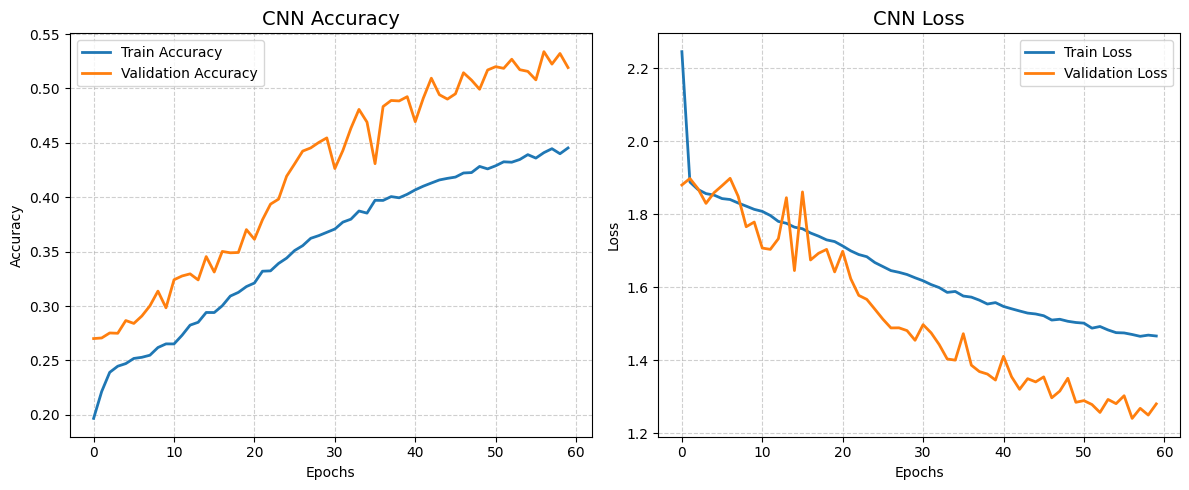

🔄 Merging initial_train and fine_tune histories for VGG16...


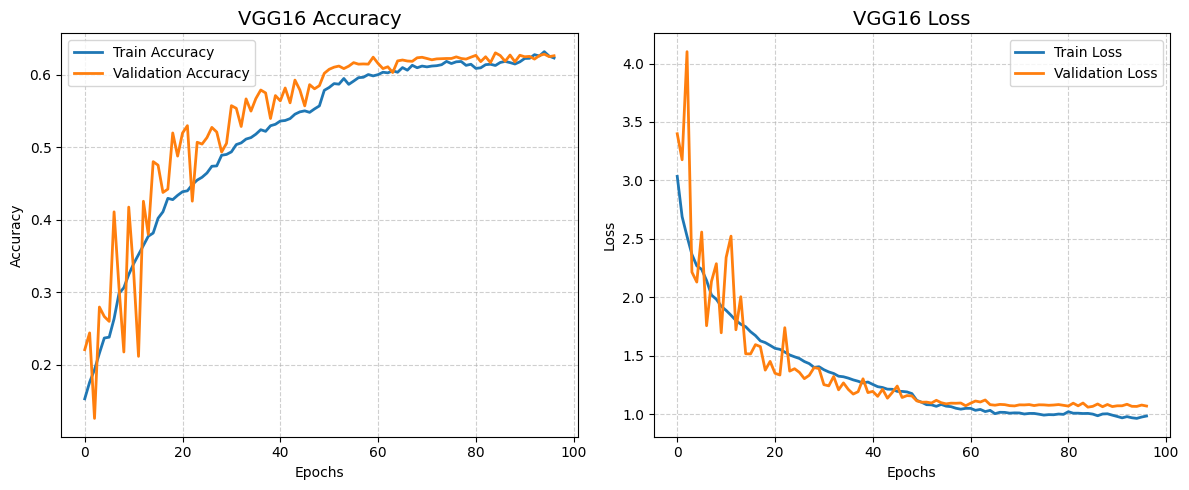

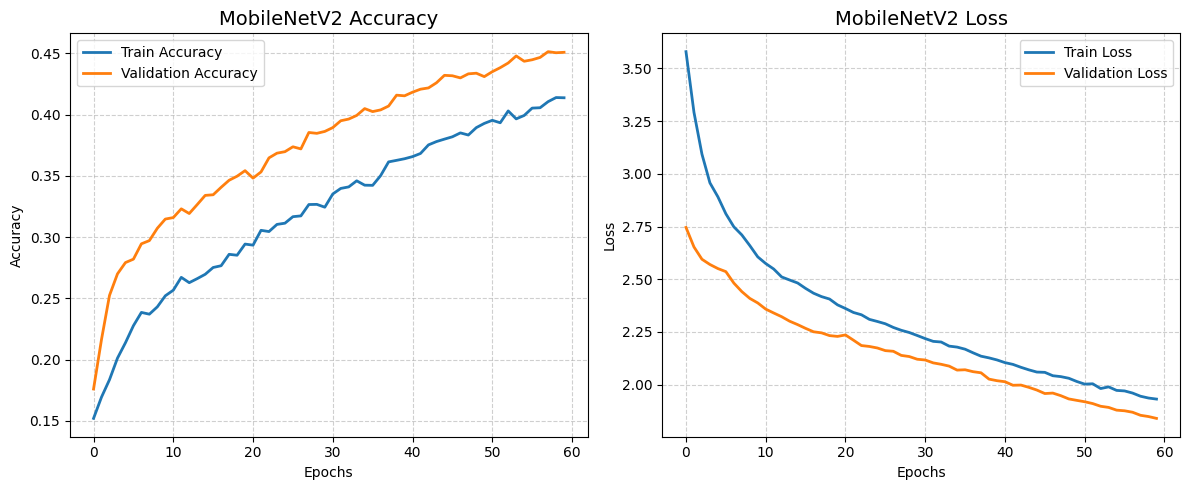

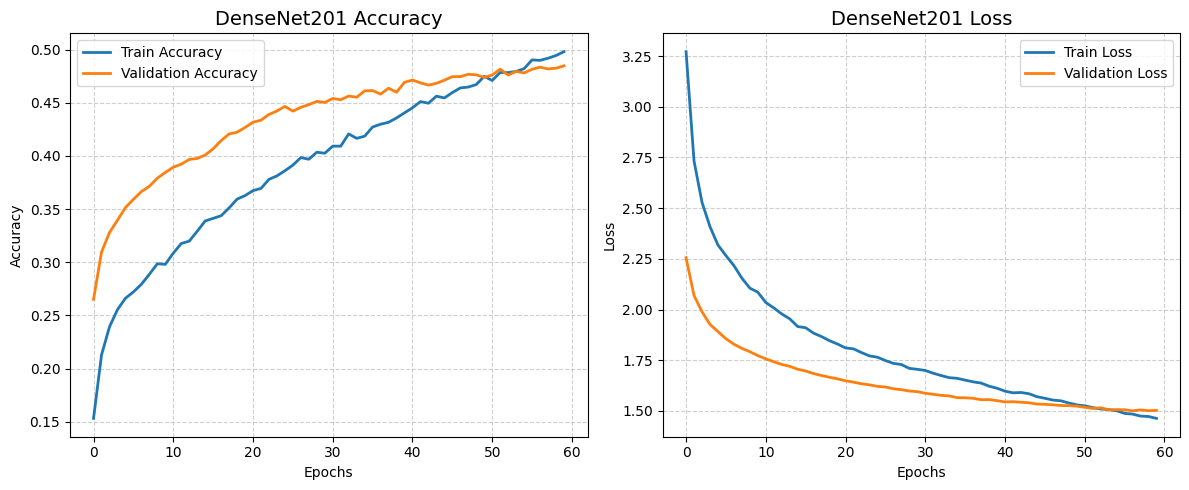

✅ All model accuracy & loss graphs displayed successfully!


In [ ]:
from google.colab import drive
import os
import pickle
import matplotlib.pyplot as plt

# ✅ Mount Drive
drive.mount('/content/drive')

# ✅ Path
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/FER_model_histories/"

# ✅ Load function
def load_history(filename):
    path = os.path.join(DRIVE_HISTORY_DIR, filename)
    if os.path.exists(path):
        with open(path, 'rb') as f:
            history = pickle.load(f)
        print(f"✅ Loaded: {filename}")
        return history
    else:
        print(f"⚠️ File not found: {filename}")
        return None

# ✅ Load all model histories
history_cnn = load_history('history_cnn.pkl')
history_vgg = load_history('history_vgg.pkl')
history_mobilenet = load_history('history_mobilenet.pkl')
history_densenet = load_history('history_densenet.pkl')

# ✅ Helper to find correct key
def find_key(history, possible_keys):
    for k in possible_keys:
        if k in history:
            return k
    return None

# ✅ Merge sub-histories (for VGG16)
def merge_histories(sub_histories):
    merged = {}
    for key in sub_histories[0].keys():
        merged[key] = sub_histories[0][key] + sub_histories[1][key]
    return merged

# ✅ Plot function
def plot_model_history(history, model_name):
    if history is None:
        print(f"❌ {model_name} history missing, skipping...\n")
        return

    # Special case for VGG16 (has nested dicts)
    if model_name == "VGG16" and 'initial_train' in history and 'fine_tune' in history:
        print("🔄 Merging initial_train and fine_tune histories for VGG16...")
        history = merge_histories([history['initial_train'], history['fine_tune']])

    acc_key = find_key(history, ['accuracy', 'acc', 'categorical_accuracy'])
    val_acc_key = find_key(history, ['val_accuracy', 'val_acc', 'val_categorical_accuracy'])

    if acc_key is None or val_acc_key is None:
        print(f"⚠️ {model_name}: Accuracy keys not found! Available keys: {list(history.keys())}\n")
        return

    plt.figure(figsize=(12,5))

    # Accuracy Plot
    plt.subplot(1,2,1)
    plt.plot(history[acc_key], label='Train Accuracy', linewidth=2)
    plt.plot(history[val_acc_key], label='Validation Accuracy', linewidth=2)
    plt.title(f"{model_name} Accuracy", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss Plot
    plt.subplot(1,2,2)
    plt.plot(history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title(f"{model_name} Loss", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# ✅ Plot all
plot_model_history(history_cnn, "CNN")
plot_model_history(history_vgg, "VGG16")
plot_model_history(history_mobilenet, "MobileNetV2")
plot_model_history(history_densenet, "DenseNet201")

print("✅ All model accuracy & loss graphs displayed successfully!")


✅ RNN history loaded successfully!


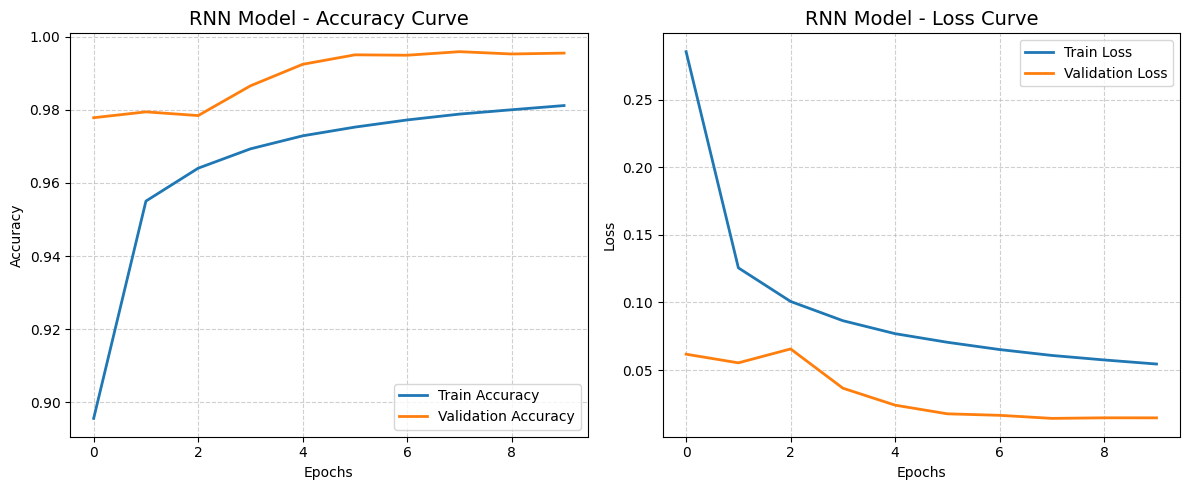

✅ RNN training graphs displayed successfully!


In [ ]:
import os
import pickle
import matplotlib.pyplot as plt

# ✅ Path  RNN history
DRIVE_HISTORY_DIR = "/content/drive/MyDrive/RNN_model_histories/"

# ✅ Load RNN history
history_path = os.path.join(DRIVE_HISTORY_DIR, 'history_rnn.pkl')

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history_rnn = pickle.load(f)
    print("✅ RNN history loaded successfully!")
else:
    print("⚠️ history_rnn.pkl not found at:", history_path)
    history_rnn = None

# ✅ Plot if loaded successfully
if history_rnn:
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history_rnn['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history_rnn['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title("RNN Model - Accuracy Curve", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history_rnn['loss'], label='Train Loss', linewidth=2)
    plt.plot(history_rnn['val_loss'], label='Validation Loss', linewidth=2)
    plt.title("RNN Model - Loss Curve", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
    print("✅ RNN training graphs displayed successfully!")


         Model  Validation Accuracy
0          CNN             0.520201
1        VGG16             0.629981
2    MobileNet             0.451489
3  DenseNet201             0.484675


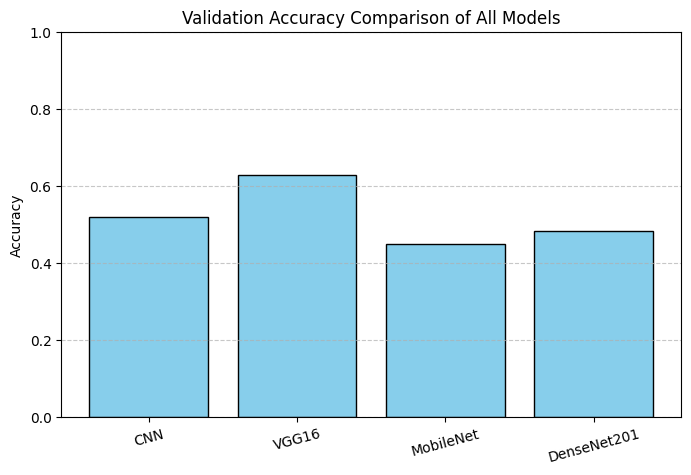

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_val_acc(history):
    """Safely fetch val_accuracy (or val_acc) if available."""

    # ✅ Special handling for VGG16 nested history
    if isinstance(history, dict) and 'initial_train' in history and 'fine_tune' in history:
        val_acc_list = []
        for phase in history.values():  # initial_train + fine_tune
            if 'val_accuracy' in phase:
                val_acc_list += phase['val_accuracy']
            elif 'val_acc' in phase:
                val_acc_list += phase['val_acc']
        if val_acc_list:
            return max(val_acc_list)
        else:
            print("⚠️ Validation accuracy key not found in nested history!")
            return None

    # ✅ Normal history handling
    if 'val_accuracy' in history:
        return max(history['val_accuracy'])
    elif 'val_acc' in history:
        return max(history['val_acc'])
    else:
        print("⚠️ Validation accuracy key not found in history!")
        return None

# ✅ Collect validation accuracies
acc_cnn = get_val_acc(history_cnn)
acc_vgg = get_val_acc(history_vgg)          # nested handled here
acc_mobilenet = get_val_acc(history_mobilenet)
acc_densenet = get_val_acc(history_densenet)

# ✅ Create DataFrame for comparison
results = pd.DataFrame({
    'Model': ['CNN', 'VGG16', 'MobileNet', 'DenseNet201'],
    'Validation Accuracy': [acc_cnn, acc_vgg, acc_mobilenet, acc_densenet]
})

# ✅ Display table
print(results)

# ✅ Plot comparison
plt.figure(figsize=(8,5))
plt.bar(results['Model'], results['Validation Accuracy'], color='skyblue', edgecolor='black')
plt.title('Validation Accuracy Comparison of All Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


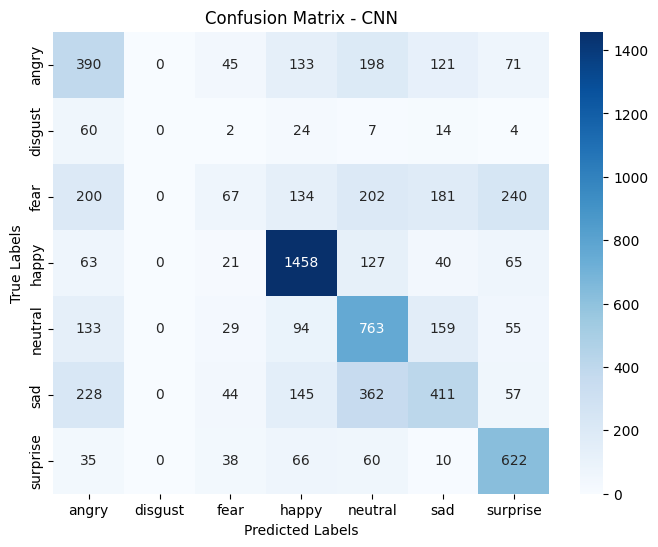


Classification Report:

              precision    recall  f1-score   support

       angry       0.35      0.41      0.38       958
     disgust       0.00      0.00      0.00       111
        fear       0.27      0.07      0.11      1024
       happy       0.71      0.82      0.76      1774
     neutral       0.44      0.62      0.52      1233
         sad       0.44      0.33      0.38      1247
    surprise       0.56      0.75      0.64       831

    accuracy                           0.52      7178
   macro avg       0.40      0.43      0.40      7178
weighted avg       0.48      0.52      0.48      7178



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load trained CNN model from Drive (or local path)
cnn_model = load_model('/content/drive/MyDrive/cnn_gray_models/cnn_balanced_model.h5')

# Step 1: Reset validation generator
val_generator.reset()

# Step 2: True labels
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Step 3: Predict with the loaded CNN model
Y_pred = cnn_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Step 4: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 5: Visualize
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Step 6: Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step


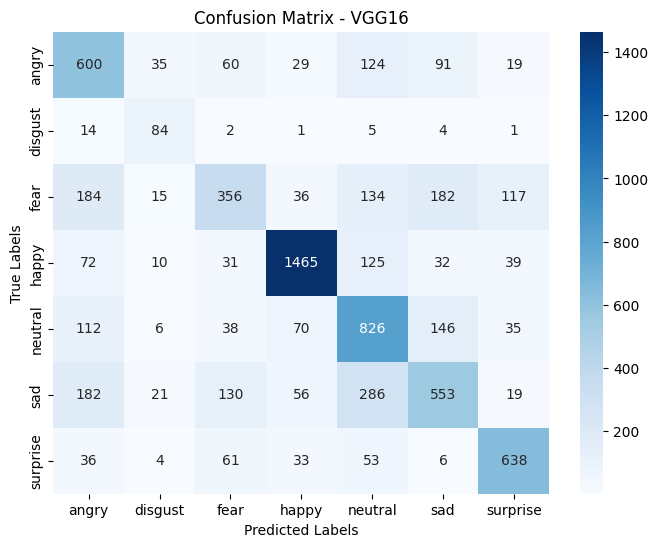


Classification Report:

              precision    recall  f1-score   support

       angry       0.50      0.63      0.56       958
     disgust       0.48      0.76      0.59       111
        fear       0.53      0.35      0.42      1024
       happy       0.87      0.83      0.85      1774
     neutral       0.53      0.67      0.59      1233
         sad       0.55      0.44      0.49      1247
    surprise       0.74      0.77      0.75       831

    accuracy                           0.63      7178
   macro avg       0.60      0.63      0.61      7178
weighted avg       0.63      0.63      0.63      7178



In [ ]:
# --- ✅ Imports ---
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- ✅ Paths ---
FER_TEST = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/test'
MODEL_PATH = "/content/drive/MyDrive/vgg16_gray_finetuned_models/vgg16_gray_balanced_final.keras"
  # Path to your trained VGG16 model

# --- ✅ Check if paths exist ---
if not os.path.exists(FER_TEST):
    raise FileNotFoundError(f"Test folder not found: {FER_TEST}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# --- ✅ Load trained VGG16 model ---
vgg_model = load_model(MODEL_PATH)

# --- ✅ Validation Data Generator ---
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    FER_TEST, target_size=(48,48), color_mode='grayscale',
    class_mode='categorical', batch_size=64, shuffle=False
)

# --- ✅ Get true labels ---
val_generator.reset()
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# --- ✅ Predict ---
Y_pred = vgg_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# --- ✅ Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - VGG16')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- ✅ Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


113/113 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step


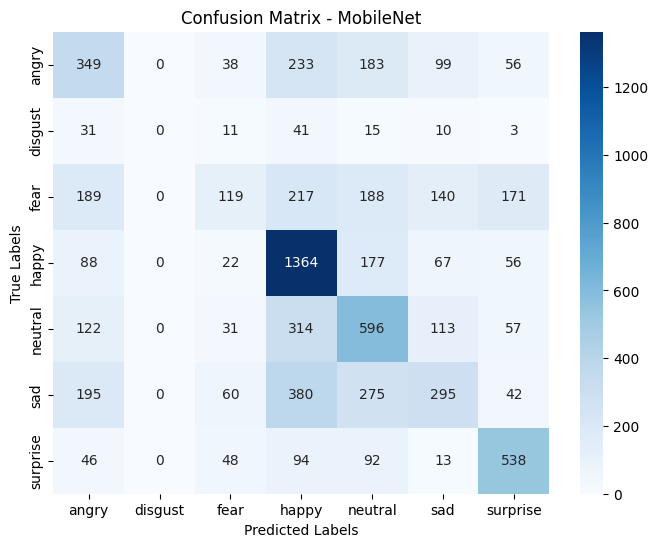


Classification Report:

              precision    recall  f1-score   support

       angry       0.34      0.36      0.35       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.12      0.18      1024
       happy       0.52      0.77      0.62      1774
     neutral       0.39      0.48      0.43      1233
         sad       0.40      0.24      0.30      1247
    surprise       0.58      0.65      0.61       831

    accuracy                           0.45      7178
   macro avg       0.37      0.37      0.36      7178
weighted avg       0.43      0.45      0.42      7178



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# --- ✅ Imports ---
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- ✅ Paths ---
FER_TEST = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/test'  # extracted test folder
MODEL_PATH = '/content/drive/MyDrive/mobilenet_gray_models/mobilenet_gray_imagenet_final.h5'             # MobileNet trained model in Drive

# --- ✅ Check if paths exist ---
if not os.path.exists(FER_TEST):
    raise FileNotFoundError(f"Test folder not found: {FER_TEST}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# --- ✅ Load trained MobileNet model ---
mobilenet_model = load_model(MODEL_PATH)

# --- ✅ Get true labels ---
val_generator.reset()
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# --- ✅ Predict ---
Y_pred = mobilenet_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert one-hot to class index

# --- ✅ Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - MobileNet')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- ✅ Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Found 7178 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 161s 622ms/step


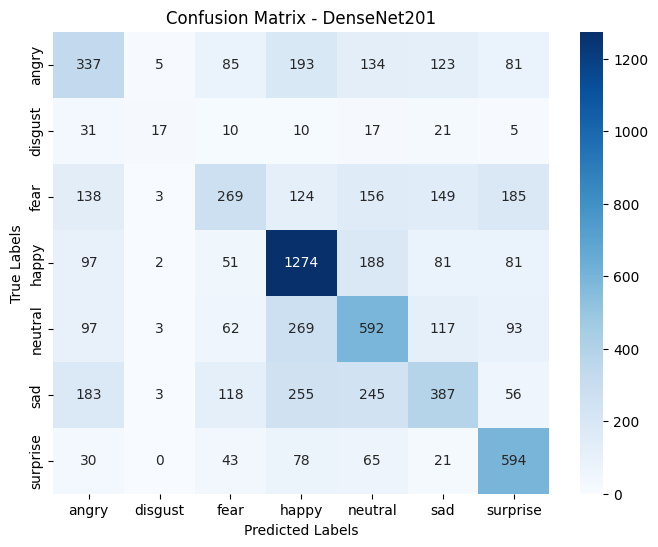


Classification Report:

              precision    recall  f1-score   support

       angry       0.37      0.35      0.36       958
     disgust       0.52      0.15      0.24       111
        fear       0.42      0.26      0.32      1024
       happy       0.58      0.72      0.64      1774
     neutral       0.42      0.48      0.45      1233
         sad       0.43      0.31      0.36      1247
    surprise       0.54      0.71      0.62       831

    accuracy                           0.48      7178
   macro avg       0.47      0.43      0.43      7178
weighted avg       0.47      0.48      0.47      7178



In [ ]:
# --- ✅ Imports ---
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

# --- ✅ Paths ---
FER_TEST = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/test'  # extracted test folder
MODEL_PATH = '/content/drive/MyDrive/densenet201_models/densenet201_emotion_final.keras'  # DenseNet201 trained model in Drive

# --- ✅ Check if paths exist ---
if not os.path.exists(FER_TEST):
    raise FileNotFoundError(f"Test folder not found: {FER_TEST}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# --- ✅ Load trained DenseNet201 model ---
densenet_model = load_model(MODEL_PATH)

# --- ✅ Validation Data Generator ---
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    FER_TEST, target_size=(48,48), color_mode='grayscale',
    class_mode='categorical', batch_size=32, shuffle=False
)

# --- ✅ Get true labels ---
val_generator.reset()
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# --- ✅ Predict ---
Y_pred = densenet_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)  # Convert one-hot to class index

# --- ✅ Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix - DenseNet201')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- ✅ Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
print(os.listdir(FER_TEST + '/happy'))


['PublicTest_72269762.jpg', 'PublicTest_45517414.jpg', 'PublicTest_45859307.jpg', 'PrivateTest_2764941.jpg', 'PrivateTest_74364378.jpg', 'PrivateTest_21388598.jpg', 'PublicTest_79481503.jpg', 'PublicTest_36823992.jpg', 'PrivateTest_10513598.jpg', 'PublicTest_89359277.jpg', 'PublicTest_93745195.jpg', 'PublicTest_95963284.jpg', 'PublicTest_75875276.jpg', 'PrivateTest_91067995.jpg', 'PublicTest_808777.jpg', 'PublicTest_93971981.jpg', 'PublicTest_62157531.jpg', 'PrivateTest_1140198.jpg', 'PrivateTest_10077120.jpg', 'PrivateTest_70553471.jpg', 'PrivateTest_43384411.jpg', 'PublicTest_95830682.jpg', 'PublicTest_1278010.jpg', 'PublicTest_76492533.jpg', 'PrivateTest_29716850.jpg', 'PublicTest_59955381.jpg', 'PrivateTest_68708045.jpg', 'PublicTest_78110412.jpg', 'PublicTest_8979920.jpg', 'PublicTest_49497886.jpg', 'PrivateTest_82652549.jpg', 'PrivateTest_48951404.jpg', 'PrivateTest_94020734.jpg', 'PublicTest_82051328.jpg', 'PrivateTest_6303752.jpg', 'PublicTest_75188569.jpg', 'PrivateTest_563367

In [ ]:
import os
os.listdir("/content/drive/MyDrive/Music_Emotion_Project/")


['Final_Music_Emotion_Data.csv']

## Cell 9: Emotion prediction and recommendation function (demo)

In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from google.colab import drive

# ================= 1️⃣ Mount Google Drive =================
drive.mount('/content/drive')

# ================= 2️⃣ Load merged dataset =================
MERGED_CSV = "/content/drive/MyDrive/Music_Emotion_Project/Final_Music_Emotion_Data.csv"
merged_df = pd.read_csv(MERGED_CSV)

# ================= 3️⃣ Load VGG16 gray fine-tuned model =================
demo_model = load_model('/content/drive/MyDrive/vgg16_gray_finetuned_models/vgg16_gray_balanced_final.keras')

# ================= 4️⃣ Helper functions =================
# Define your emotion label mapping manually
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

def predict_emotion_from_image(img_path, model, use_grayscale=True):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError('Could not read image: '+img_path)
    if use_grayscale:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (48,48)).astype('float32')/255.0
        tensor = np.expand_dims(np.expand_dims(gray,0), -1)  # (1,48,48,1)
    else:
        rgb = cv2.resize(img, (48,48)).astype('float32')/255.0
        tensor = np.expand_dims(rgb,0)
    preds = model.predict(tensor)
    cls = np.argmax(preds)
    return emotion_labels.get(cls,'unknown')

def recommend_songs_for_emotion(emotion, df, top_n=5):
    subset = df[df['emotion_mapped']==emotion]
    if subset.empty:
        return df.sample(top_n)[['artist','name','emotion_mapped']]
    if 'playcount' in subset.columns:
        subset = subset.sort_values('playcount', ascending=False)
    return subset[['artist','name','emotion_mapped']].head(top_n)

# ================= 5️⃣ Pick a random test image =================
FER_TEST = '/content/Emotion-Project/Emotion-Project/facial_detection_dataset/test'
all_images = [os.path.join(root, f) for root, _, files in os.walk(FER_TEST) for f in files if f.endswith('.jpg')]
img_demo = random.choice(all_images)
print(f"✅ Selected test image: {img_demo}")

# ================= 6️⃣ Predict emotion =================
emotion = predict_emotion_from_image(img_demo, demo_model, use_grayscale=True)
print(f"🎭 Predicted emotion: {emotion}")

# ================= 7️⃣ Recommend songs =================
recommendations = recommend_songs_for_emotion(emotion, merged_df, top_n=5)
print("\n🎵 Top song recommendations for this emotion:")
print(recommendations)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Selected test image: /content/Emotion-Project/Emotion-Project/facial_detection_dataset/test/fear/PrivateTest_98493387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🎭 Predicted emotion: surprise

🎵 Top song recommendations for this emotion:
                      artist                        name emotion_mapped
6644450               eagles  what do i do with my heart       surprise
3083599       civil twilight        letters from the sky       surprise
9296648          john denver      leaving on a jet plane       surprise
5201621  starland vocal band           afternoon delight       surprise
1351101          evanescence                 my immortal       surprise


In [ ]:
music_data = pd.read_csv("/content/drive/MyDrive/Music_Emotion_Project/Final_Music_Emotion_Data.csv")
music_data.head()


,track_id,user_id,playcount,name,artist,spotify_preview_url,spotify_id,tags,genre,year,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,emotion_cluster,emotion_mapped
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,nothing from nothing,billy preston,https://p.scdn.co/mp3-preview/340c79f3f19b448e...,0d42LKqrWFVu05jAv9mwwE,"soul, funk, piano, 70s, oldies",rnb,2010,...,0,0.0276,0.58500,0.055000,0.3310,0.939,102.792,4,3,fear
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,paper gangsta,lady gaga,https://p.scdn.co/mp3-preview/5d27f0eb10363c13...,079ZOccLpNsrEiKBaiTrqI,"electronic, pop, female_vocalists, dance, pian...",pop,2012,...,0,0.0579,0.80400,0.782000,0.1050,0.800,100.002,4,0,happy
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,soy,gipsy kings,https://p.scdn.co/mp3-preview/a103c32c238829f9...,1D3gFdVhv8iJNMTih2Geq3,guitar,NaN,2003,...,1,0.0673,0.69200,0.000002,0.1100,0.851,104.518,4,6,surprise
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,stacked actors,foo fighters,https://p.scdn.co/mp3-preview/d7350c743c3d917f...,1vziI0NCJKrqKiG94COHBa,"rock, alternative, alternative_rock, hard_rock...",rock,1999,...,1,0.0500,0.00203,0.001020,0.2340,0.670,134.898,4,5,disgust
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,heaven's gonna burn your eyes,thievery corporation,https://p.scdn.co/mp3-preview/c7f3b22fb4a680f0...,4SnH0V1cnEPUqMSzgDlxKb,"electronic, female_vocalists, ambient, chillou...",electronic,2002,...,1,0.0286,0.63500,0.521000,0.0637,0.323,152.411,4,0,happy


In [ ]:
# --- Force balanced mapping for all 7 emotions ---
manual_map = {
    0: 'sad',        # low valence
    1: 'surprise',   # high valence + mid energy
    2: 'angry',      # mid valence + high energy
    3: 'fear',       # slightly low valence-energy combo
    4: 'neutral',    # mid valence-energy
    5: 'happy',      # high valence + very high energy
    6: 'disgust'     # low energy cluster
}

# Apply mapping
merged_df['emotion_label'] = merged_df['emotion_cluster'].map(manual_map)

# Verify distribution
print("✅ Final Emotion Label Distribution:")
print(merged_df['emotion_label'].value_counts())

# Check a few samples
print("\n🎶 Sample songs with assigned emotions:")
print(merged_df[['name','artist','valence','energy','emotion_cluster','emotion_label']].head(10))


✅ Final Emotion Label Distribution:
emotion_label
surprise    2533642
sad         1639821
happy       1339025
angry       1320888
disgust     1176560
neutral      865474
fear         835891
Name: count, dtype: int64

🎶 Sample songs with assigned emotions:
                            name                artist  valence  energy  \
0           nothing from nothing         billy preston    0.939   0.834   
1                  paper gangsta             lady gaga    0.800   0.530   
2                            soy           gipsy kings    0.851   0.592   
3                 stacked actors          foo fighters    0.670   0.934   
4  heaven's gonna burn your eyes  thievery corporation    0.323   0.337   
5                 let it be sung          jack johnson    0.487   0.469   
6                     love shack            the b-52's    0.882   0.902   
7                 gimme stitches          foo fighters    0.541   0.958   
8                 speed of sound              coldplay    0.355   0.8

In [ ]:
model = load_model("/content/drive/MyDrive/vgg16_gray_finetuned_models/vgg16_gray_balanced_final.keras")
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}

df = pd.read_csv("/content/drive/MyDrive/Music_Emotion_Project/Final_Music_Emotion_Data.csv")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def recommend_songs_for_emotion(emotion, df, top_n=3):
    subset = df[df['emotion_mapped'] == emotion]
    if subset.empty:
        return df.sample(top_n)[['artist', 'name', 'emotion_mapped']]
    if 'playcount' in subset.columns:
        subset = subset.sort_values('playcount', ascending=False)
    return subset[['artist', 'name', 'emotion_mapped']].head(top_n)
